In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output="pandas")

random_state = 42

# Подключим датафрейм и выгрузим данные
df = pd.read_csv("data/house_data.csv")

### Устраняем выбросы в колонке цены и добавляем колонку с категориями цены

In [158]:


# Добавляем столбец с категорями цены
df['price_category'] = pd.cut(df['price'], bins=[75000,338750,602750,866750,1130750], labels=['low','middle','high','very_high'], include_lowest=True)
df.tail(20)


id             date      price  bedrooms  bathrooms  \
21593  8672200110  20150317T000000  1088000.0         5       3.75   
21594  5087900040  20141017T000000   350000.0         4       2.75   
21595  1972201967  20141031T000000   520000.0         2       2.25   
21596  7502800100  20140813T000000   679950.0         5       2.75   
21597   191100405  20150421T000000  1575000.0         4       3.25   
21598  8956200760  20141013T000000   541800.0         4       2.50   
21599  7202300110  20140915T000000   810000.0         4       3.00   
21600   249000205  20141015T000000  1537000.0         5       3.75   
21601  5100403806  20150407T000000   467000.0         3       2.50   
21602   844000965  20140626T000000   224000.0         3       1.75   
21603  7852140040  20140825T000000   507250.0         3       2.50   
21604  9834201367  20150126T000000   429000.0         3       2.00   
21605  3448900210  20141014T000000   610685.0         4       2.50   
21606  7936000429  20150326T000000  1007500.0         4       3.50   
21607  2997800021  20150219T000000   475000.0         3       2.50   
21608   263000018  20140521T000000   360000.0         3       2.50   
21609  6600060120  20150223T000000   400000.0         4       2.50   
21610  1523300141  20140623T000000   402101.0         2       0.75   
21611   291310100  20150116T000000   400000.0         3       2.50   
21612  1523300157  20141015T000000   325000.0         2       0.75   

       sqft_living  sqft_lot  floors  waterfront  view  ...  sqft_above  \
21593         4170      8142     2.0           0     2  ...        4170   
21594         2500      5995     2.0           0     0  ...        2500   
21595         1530       981     3.0           0     0  ...        1480   
21596         3600      9437     2.0           0     0  ...        3600   
21597         3410     10125     2.0           0     0  ...        3410   
21598         3118      7866     2.0           0     2  ...        3118   
21599         3990      7838     2.0           0     0  ...        3990   
21600         4470      8088     2.0           0     0  ...        4470   
21601         1425      1179     3.0           0     0  ...        1425   
21602         1500     11968     1.0           0     0  ...        1500   
21603         2270      5536     2.0           0     0  ...        2270   
21604         1490      1126     3.0           0     0  ...        1490   
21605         2520      6023     2.0           0     0  ...        2520   
21606         3510      7200     2.0           0     0  ...        2600   
21607         1310      1294     2.0           0     0  ...        1180   
21608         1530      1131     3.0           0     0  ...        1530   
21609         2310      5813     2.0           0     0  ...        2310   
21610         1020      1350     2.0           0     0  ...        1020   
21611         1600      2388     2.0           0     0  ...        1600   
21612         1020      1076     2.0           0     0  ...        1020   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
21593              0      2006             0    98056  47.5354 -122.181   
21594              0      2008             0    98042  47.3749 -122.107   
21595             50      2006             0    98103  47.6533 -122.346   
21596              0      2014             0    98059  47.4822 -122.131   
21597              0      2007             0    98040  47.5653 -122.223   
21598              0      2014             0    98001  47.2931 -122.264   
21599              0      2003             0    98053  47.6857 -122.046   
21600              0      2008             0    98004  47.6321 -122.200   
21601              0      2008             0    98125  47.6963 -122.318   
21602              0      2014             0    98010  47.3095 -122.002   
21603              0      2003             0    98065  47.5389 -121.881   
21604              0      2014             0    98144  47.5699 -122.

### Бизнес-цели
1. Задача регрессии – предсказание цены дома (price). Это может помочь риэлторам и аналитикам определить справедливую рыночную стоимость недвижимости.

2. Задача классификации – определение вероятности того, что цена дома будет выше/ниже медианы рынка. Классифицировать дома по ценовым категориям (например, низкая, средняя, высокая цена). Это может помочь определить, какие дома популярны у покупателей.

### Определение достижимого уровня качества модели для задачи классификации
#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи классификации (Целевой признак - median_price)

In [159]:
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

# Создание целевого признака
median_price = df['price'].median()
df['median_price'] = np.where(df['price'] > median_price, 1, 0)

# Разделение на признаки и целевую переменную
X = df.drop(columns=['id', 'date', 'price', 'median_price'])
y = df['median_price']

# Примерная категоризация
df['price_category'] = pd.cut(df['price'], bins=[0, 300000, 700000, np.inf], labels=[0, 1, 2])

# Выбор признаков и целевых переменных
X = df.drop(columns=['id', 'date', 'price', 'price_category'])


def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:
   
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )
    
    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))
    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.
    
    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    if frac_val <= 0:
        assert len(df_input) == len(df_train) + len(df_temp)
        return df_train, pd.DataFrame(), df_temp, y_train, pd.DataFrame(), y_temp
    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)

    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_stratified_into_train_val_test(
    df, stratify_colname="median_price", frac_train=0.80, frac_val=0, frac_test=0.20, random_state=42
)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

print(df.dtypes)

'X_train'

id             date      price  bedrooms  bathrooms  \
20962  1278000210  20150311T000000   110000.0         2       1.00   
12284  2193300390  20140923T000000   624000.0         4       3.25   
7343   4289900005  20141230T000000  1535000.0         4       3.25   
14247   316000145  20150325T000000   235000.0         4       1.00   
16670   629400480  20140619T000000   775000.0         4       2.75   
...           ...              ...        ...       ...        ...   
88     1332700270  20140519T000000   215000.0         2       2.25   
15031  7129303070  20140820T000000   735000.0         4       2.75   
5234   2432000130  20150414T000000   675000.0         3       1.75   
19980   774100475  20140627T000000   415000.0         3       2.75   
3671   8847400115  20140723T000000   590000.0         3       2.00   

       sqft_living  sqft_lot  floors  waterfront  view  ...  sqft_basement  \
20962          828      4524     1.0           0     0  ...              0   
12284         2810     11250     1.0           0     0  ...           1130   
7343          2850      4100     2.0           0     3  ...           1030   
14247         1360      7132     1.5           0     0  ...              0   
16670         3010     15992     2.0           0     0  ...              0   
...            ...       ...     ...         ...   ...  ...            ...   
88            1610      2040     2.0           0     0  ...              0   
15031         3040      2415     2.0           1     4  ...              0   
5234          1660      9549     1.0           0     0  ...              0   
19980         2600     64626     1.5           0     0  ...              0   
3671          2420    208652     1.5           0     0  ...              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
20962      1968          2007    98001  47.2655 -122.244            828   
12284      1980             0    98052  47.6920 -122.099           2110   
7343       1908          2003    98122  47.6147 -122.285           2130   
14247      1941             0    98168  47.5054 -122.301           1280   
16670      1996             0    98075  47.5895 -121.994           3330   
...         ...           ...      ...      ...      ...            ...   
88         1979             0    98056  47.5180 -122.194           1950   
15031      1966             0    98118  47.5188 -122.256           2620   
5234       1956             0    98033  47.6503 -122.198           2090   
19980      2009             0    98014  47.7185 -121.405           1740   
3671       2005             0    98010  47.3666 -121.978           3180   

       sqft_lot15  price_category  median_price  
20962        5402               0             0  
12284       11250               1             1  
7343         4200               2             1  
14247        7175               0             0  
16670       12333               2             1  
...           ...             ...           ...  
88           2025               0             0  
15031        2433               2             1  
5234         9549               1             1  
19980       64626               1             0  
3671       212137               1             1  

[17290 rows x 23 columns]

'y_train'

median_price
20962             0
12284             1
7343              1
14247             0
16670             1
...             ...
88                0
15031             1
5234              1
19980             0
3671              1

[17290 rows x 1 columns]

'X_test'

id             date      price  bedrooms  bathrooms  \
11592  2028701000  20140529T000000   635200.0         4       1.75   
8984   9406500530  20140912T000000   249000.0         2       2.00   
8280   8097000330  20140721T000000   359950.0         3       2.75   
792    8081020370  20140709T000000  1355000.0         4       3.50   
10371  7518507580  20150502T000000   581000.0         2       1.00   
...           ...              ...        ...       ...        ...   
16733  7212650950  20140708T000000   336000.0         4       2.50   
13151  4365200620  20150312T000000   394000.0         3       1.00   
11667  4083304355  20150318T000000   675000.0         4       1.75   
3683   2891100820  20140825T000000   213500.0         3       1.00   
12059   952000640  20141027T000000   715000.0         3       1.50   

       sqft_living  sqft_lot  floors  waterfront  view  ...  sqft_basement  \
11592         1640      4240     1.0           0     0  ...            720   
8984          1090      1357     2.0           0     0  ...              0   
8280          2540      8604     2.0           0     0  ...              0   
792           3550     11000     1.0           0     2  ...           1290   
10371         1170      4080     1.0           0     0  ...              0   
...            ...       ...     ...         ...   ...  ...            ...   
16733         2530      8169     2.0           0     0  ...              0   
13151         1450      7930     1.0           0     0  ...            300   
11667         1530      3615     1.5           0     0  ...              0   
3683          1220      6000     1.0           0     0  ...              0   
12059         1670      5060     2.0           0     2  ...              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
11592      1921             0    98117  47.6766 -122.368           1300   
8984       1990             0    98028  47.7526 -122.244           1078   
8280       1991             0    98092  47.3209 -122.185           2260   
792        1999             0    98006  47.5506 -122.134           4100   
10371      1909             0    98117  47.6784 -122.386           1560   
...         ...           ...      ...      ...      ...            ...   
16733      1993             0    98003  47.2634 -122.312           2220   
13151      1923             0    98126  47.5212 -122.371           1040   
11667      1913             0    98103  47.6529 -122.334           1650   
3683       1968             0    98002  47.3245 -122.209           1420   
12059      1925             0    98126  47.5671 -122.379           1670   

       sqft_lot15  price_category  median_price  
11592        4240               1             1  
8984         1318               0             0  
8280         7438               1             0  
792         10012               2             1  
10371        4586               1             1  
...           ...             ...           ...  
16733        8013               1             0  
13151        7740               1             0  
11667        4200               1             1  
3683         6000               0             0  
12059        5118               2             1  

[4323 rows x 23 columns]

'y_test'

median_price
11592             1
8984              0
8280              0
792               1
10371             1
...             ...
16733             0
13151             0
11667             1
3683              0
12059             1

[4323 rows x 1 columns]

id                   int64
date                object
price              float64
bedrooms             int64
bathrooms          float64
sqft_living          int64
sqft_lot             int64
floors             float64
waterfront           int64
view                 int64
condition            int64
grade                int64
sqft_above           int64
sqft_basement        int64
yr_built             int64
yr_renovated         int64
zipcode              int64
lat                float64
long               float64
sqft_living15        int64
sqft_lot15           int64
price_category    category
median_price         int64
dtype: object


### Формирование конвейера
preprocessing_num -- конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

preprocessing_cat -- конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

features_preprocessing -- трансформер для предобработки признаков

drop_columns -- трансформер для удаления колонок

pipeline_end -- основной конвейер предобработки данных и конструирования признаков

In [160]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor  # Пример регрессионной модели
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline_end = StandardScaler()


class HouseFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Создание новых признаков
        X = X.copy()
        X["Living_area_to_Lot_ratio"] = X["sqft_living"] / X["sqft_lot"]
        return X
    def get_feature_names_out(self, features_in):
        # Добавление имен новых признаков
        new_features = ["Living_area_to_Lot_ratio"]
        return np.append(features_in, new_features, axis=0)

#Предобработка числовых значений. Заполнение пустых значений на медиану.
preprocessing_num_class = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Предобработка категориальных значений
preprocessing_cat_class = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

columns_to_drop = ["date"]
numeric_columns = ["sqft_living", "sqft_lot", "median_price"]
cat_columns = []

features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("prepocessing_num", preprocessing_num_class, numeric_columns),
        ("prepocessing_cat", preprocessing_cat_class, cat_columns),
    ],
    remainder="passthrough"
)

drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("custom_features", HouseFeatures()),
        ("drop_columns", drop_columns),
    ]
)

### Пример работы конвейера.

In [161]:
preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df

sqft_living  sqft_lot  median_price          id      price  bedrooms  \
20962    -1.360742 -0.262132     -0.994693  1278000210   110000.0         2   
12284     0.794390 -0.094121      1.005335  2193300390   624000.0         4   
7343      0.837884 -0.272723      1.005335  4289900005  1535000.0         4   
14247    -0.782270 -0.196986     -0.994693   316000145   235000.0         4   
16670     1.011860  0.024330      1.005335   629400480   775000.0         4   
...            ...       ...           ...         ...        ...       ...   
88       -0.510432 -0.324180     -0.994693  1332700270   215000.0         2   
15031     1.044481 -0.314813      1.005335  7129303070   735000.0         4   
5234     -0.456065 -0.136611      1.005335  2432000130   675000.0         3   
19980     0.566046  1.239169     -0.994693   774100475   415000.0         3   
3671      0.370323  4.836825      1.005335  8847400115   590000.0         3   

       bathrooms  floors  waterfront  view  ...  sqft_basement  yr_built  \
20962       1.00     1.0           0     0  ...              0      1968   
12284       3.25     1.0           0     0  ...           1130      1980   
7343        3.25     2.0           0     3  ...           1030      1908   
14247       1.00     1.5           0     0  ...              0      1941   
16670       2.75     2.0           0     0  ...              0      1996   
...          ...     ...         ...   ...  ...            ...       ...   
88          2.25     2.0           0     0  ...              0      1979   
15031       2.75     2.0           1     4  ...              0      1966   
5234        1.75     1.0           0     0  ...              0      1956   
19980       2.75     1.5           0     0  ...              0      2009   
3671        2.00     1.5           0     0  ...              0      2005   

       yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
20962          2007    98001  47.2655 -122.244            828        5402   
12284             0    98052  47.6920 -122.099           2110       11250   
7343           2003    98122  47.6147 -122.285           2130        4200   
14247             0    98168  47.5054 -122.301           1280        7175   
16670             0    98075  47.5895 -121.994           3330       12333   
...             ...      ...      ...      ...            ...         ...   
88                0    98056  47.5180 -122.194           1950        2025   
15031             0    98118  47.5188 -122.256           2620        2433   
5234              0    98033  47.6503 -122.198           2090        9549   
19980             0    98014  47.7185 -121.405           1740       64626   
3671              0    98010  47.3666 -121.978           3180      212137   

       price_category  Living_area_to_Lot_ratio  
20962               0                  5.191063  
12284               1                 -8.440052  
7343                2                 -3.072292  
14247               0                  3.971201  
16670               2                 41.589045  
...               ...                       ...  
88                  0                  1.574534  
15031               2                 -3.317784  
5234                1                  3.338418  
19980               1                  0.456795  
3671                1                  0.076563  

[17290 rows x 23 columns]

### Формирование набора моделей для классификации¶
logistic -- логистическая регрессия

ridge -- гребневая регрессия

decision_tree -- дерево решений

knn -- k-ближайших соседей

naive_bayes -- наивный Байесовский классификатор

gradient_boosting -- метод градиентного бустинга (набор деревьев решений)

random_forest -- метод случайного леса (набор деревьев решений)

mlp -- многослойный персептрон (нейронная сеть)

In [162]:
from sklearn import ensemble, linear_model, naive_bayes, neighbors, neural_network, tree, svm

class_models = {
    "logistic": {"model": linear_model.LogisticRegression(max_iter=150)},
    "ridge": {"model": linear_model.RidgeClassifierCV(cv=5, class_weight="balanced")},
    "ridge": {"model": linear_model.LogisticRegression(max_iter=150, solver='lbfgs', penalty="l2", class_weight="balanced")},
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=random_state)
    },

    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },

    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=5, class_weight="balanced", random_state=random_state
        )
    },

    "mlp": {
        "model": neural_network.MLPClassifier(
            hidden_layer_sizes=(7,),
            max_iter=200,
            early_stopping=True,
            random_state=random_state,
        )
    },
}

### Обучение моделей на обучающем наборе данных и оценка на тестовом

In [163]:
import numpy as np
from sklearn import metrics

for model_name in class_models.keys():
    print(f"Model: {model_name}")
    model = class_models[model_name]["model"]

    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    y_train_predict = model_pipeline.predict(X_train)
    y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
    y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["probs"] = y_test_probs
    class_models[model_name]["preds"] = y_test_predict

    class_models[model_name]["Precision_train"] = metrics.precision_score(
        y_train, y_train_predict, zero_division=1
    )
    class_models[model_name]["Precision_test"] = metrics.precision_score(
        y_test, y_test_predict, zero_division=1
    )
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test, y_test_predict
    )
    class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
        y_test, y_test_probs
    )
    class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict)
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict)
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test, y_test_predict
    )
    class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
        y_test, y_test_predict
    )

Model: logistic
Model: ridge
Model: decision_tree
Model: knn
Model: naive_bayes
Model: gradient_boosting
Model: random_forest
Model: mlp


### Сводная таблица оценок качества для использованных моделей классификации. Матрица неточностей

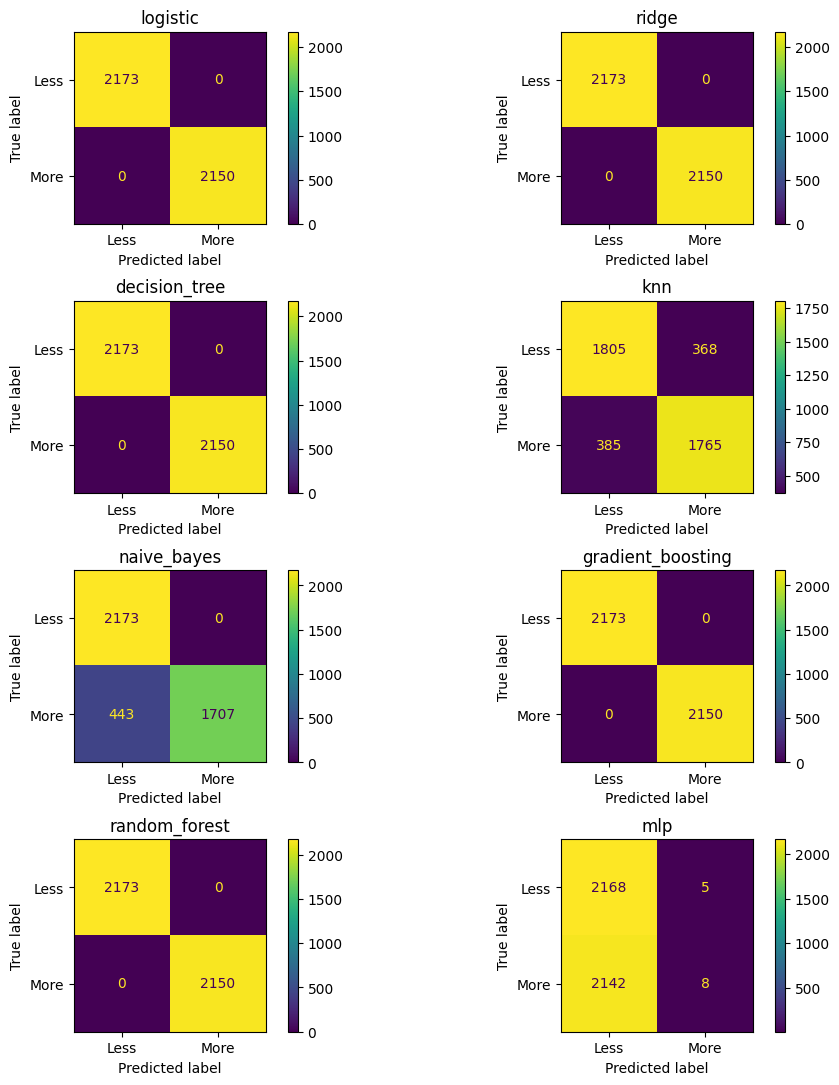

In [164]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)
for index, key in enumerate(class_models.keys()):
    c_matrix = class_models[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Less", "More"]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

На данных графиках, левый нижний квадрат обозначает, кол-во правильно классифицированных значениях, относимых к классу "Less", чем больше число в этом квадрате, тем лучше модель может классифицировать этот класс. Нижний левый квадрат отвечает за кол-во правильно классифицированных значениях "More". Здесь так же как и в левом верхнем, чем выше значение, тем лучше.

### Точность, полнота, верность (аккуратность), F-мера

In [165]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

100% точности у модели может свидетельствовать о ее переобучении, то есть модели обучилась классифицировать значения только для обучающей выборки, но на тестовой выборке результаты будут плохими.

### ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса

In [166]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]
class_metrics.sort_values(by="ROC_AUC_test", ascending=False).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

### Вывод лучшей модели

In [167]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'logistic'

### Вывод данных с ошибкой предсказания для оценки

In [168]:
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

y_pred = class_models[best_model]["preds"]

error_index = y_test[y_test["median_price"] != y_pred].index.tolist()
display(f"Error items count: {len(error_index)}")

error_predicted = pd.Series(y_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df.sort_index()

'Error items count: 0'

Empty DataFrame
Columns: [id, Predicted, date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15, price_category, median_price]
Index: []

[0 rows x 24 columns]

### Пример использования обученной модели (конвейера) для предсказания

In [169]:
model = class_models[best_model]["pipeline"]

example_id = 11592
test = pd.DataFrame(X_test.loc[example_id, :]).T
test_preprocessed = pd.DataFrame(preprocessed_df.loc[example_id, :]).T
display(test)
display(test_preprocessed)
result_proba = model.predict_proba(test)[0]
result = model.predict(test)[0]
real = int(y_test.loc[example_id].values[0])
display(f"predicted: {result} (proba: {result_proba})")
display(f"real: {real}")

id             date     price bedrooms bathrooms sqft_living  \
11592  2028701000  20140529T000000  635200.0        4      1.75        1640   

      sqft_lot floors waterfront view  ... sqft_basement yr_built  \
11592     4240    1.0          0    0  ...           720     1921   

      yr_renovated zipcode      lat     long sqft_living15 sqft_lot15  \
11592            0   98117  47.6766 -122.368          1300       4240   

      price_category median_price  
11592              1            1  

[1 rows x 23 columns]

sqft_living  sqft_lot  median_price            id     price  bedrooms  \
11592    -0.477812 -0.269226      1.005335  2.028701e+09  635200.0       4.0   

       bathrooms  floors  waterfront  view  ...  sqft_basement  yr_built  \
11592       1.75     1.0         0.0   0.0  ...          720.0    1921.0   

       yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
11592           0.0  98117.0  47.6766 -122.368         1300.0      4240.0   

       price_category  Living_area_to_Lot_ratio  
11592             1.0                  1.774763  

[1 rows x 23 columns]

'predicted: 1 (proba: [0. 1.])'

'real: 1'

### Подбор гиперпараметров методом поиска по сетке

In [170]:
from sklearn.model_selection import GridSearchCV

optimized_model_type = "random_forest"

random_forest_model = class_models[optimized_model_type]["pipeline"]

param_grid = {
    "model__n_estimators": [10, 50, 100],
    "model__max_features": ["sqrt", "log2"],
    "model__max_depth": [5, 7, 10],
    "model__criterion": ["gini", "entropy"],
}

gs_optomizer = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, n_jobs=-1
)
gs_optomizer.fit(X_train, y_train.values.ravel())
gs_optomizer.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 5,
 'model__max_features': 'sqrt',
 'model__n_estimators': 10}

### Обучение модели с новыми гиперпараметрами

In [171]:
optimized_model = ensemble.RandomForestClassifier(
    random_state=random_state,
    criterion="gini",
    max_depth=5,
    max_features="sqrt",
    n_estimators=10,
)

result = {}

result["pipeline"] = Pipeline([("pipeline", pipeline_end), ("model", optimized_model)]).fit(X_train, y_train.values.ravel())
result["train_preds"] = result["pipeline"].predict(X_train)
result["probs"] = result["pipeline"].predict_proba(X_test)[:, 1]
result["preds"] = np.where(result["probs"] > 0.5, 1, 0)

result["Precision_train"] = metrics.precision_score(y_train, result["train_preds"])
result["Precision_test"] = metrics.precision_score(y_test, result["preds"])
result["Recall_train"] = metrics.recall_score(y_train, result["train_preds"])
result["Recall_test"] = metrics.recall_score(y_test, result["preds"])
result["Accuracy_train"] = metrics.accuracy_score(y_train, result["train_preds"])
result["Accuracy_test"] = metrics.accuracy_score(y_test, result["preds"])
result["ROC_AUC_test"] = metrics.roc_auc_score(y_test, result["probs"])
result["F1_train"] = metrics.f1_score(y_train, result["train_preds"])
result["F1_test"] = metrics.f1_score(y_test, result["preds"])
result["MCC_test"] = metrics.matthews_corrcoef(y_test, result["preds"])
result["Cohen_kappa_test"] = metrics.cohen_kappa_score(y_test, result["preds"])
result["Confusion_matrix"] = metrics.confusion_matrix(y_test, result["preds"])

### Формирование данных для оценки старой и новой версии модели

In [172]:
optimized_metrics = pd.DataFrame(columns=list(result.keys()))
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=class_models[optimized_model_type]
)
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=result
)
optimized_metrics.insert(loc=0, column="Name", value=["Old", "New"])
optimized_metrics = optimized_metrics.set_index("Name")

### Оценка параметров старой и новой модели

In [173]:
optimized_metrics[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

Значения 1 в кажой ячейке обосзначают, что модели очень точно классифицируют положительные образцы, не пропуская их.

In [174]:
optimized_metrics[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

Значения 1 в кажой ячейке обосзначают, что модели точно классифицировали все тестовые примеры, не допустив никаких ошибок в предсказаниях.

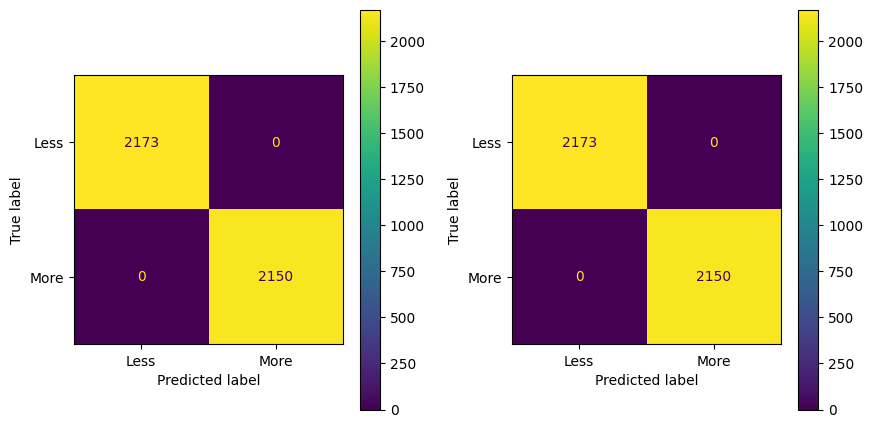

In [175]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False
)

for index in range(0, len(optimized_metrics)):
    c_matrix = optimized_metrics.iloc[index]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Less", "More"]
    ).plot(ax=ax.flat[index])

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.3)
plt.show()

### Задача регресии: предсказание цены дома (price).

In [176]:
# Вычисление среднего значения поля "sqft_living"
average_price = df['sqft_living'].mean()
print(f"Среднее значение поля: {average_price}")

# Создание новой колонки, указывающей, выше или ниже среднего значение цена закрытия
df['average_price'] = (df['sqft_living'] > average_price).astype(int)

df.dropna(inplace=True)
df.head()

Среднее значение поля: 2079.8997362698374


id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  yr_built  yr_renovated  zipcode  \
0      5650     1.0           0     0  ...      1955             0    98178   
1      7242     2.0           0     0  ...      1951          1991    98125   
2     10000     1.0           0     0  ...      1933             0    98028   
3      5000     1.0           0     0  ...      1965             0    98136   
4      8080     1.0           0     0  ...      1987             0    98074   

       lat     long  sqft_living15  sqft_lot15  price_category  median_price  \
0  47.5112 -122.257           1340        5650               0             0   
1  47.7210 -122.319           1690        7639               1             1   
2  47.7379 -122.233           2720        8062               0             0   
3  47.5208 -122.393           1360        5000               1             1   
4  47.6168 -122.045           1800        7503               1             1   

   average_price  
0              0  
1              1  
2              0  
3              0  
4              0  

[5 rows x 24 columns]

### Делим DF на выборки

In [179]:
from typing import Tuple
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_into_train_test(
    df_input: DataFrame,
    target_colname: str = "average_price",
    frac_train: float = 0.8,
    random_state: int = None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    # Проверка наличия целевого признака
    if target_colname not in df_input.columns:
        raise ValueError(f"{target_colname} is not a column in the DataFrame.")
    
    # Разделяем данные на признаки и целевую переменную
    X = df_input.drop(columns=[target_colname])  # Признаки
    y = df_input[[target_colname]]  # Целевая переменная

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_into_train_test(
    df, 
    target_colname="average_price", 
    frac_train=0.8, 
    random_state=42
)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

id             date     price  bedrooms  bathrooms  \
6325   5467910190  20140527T000000  325000.0         3       1.75   
13473  9331800580  20150310T000000  257000.0         2       1.00   
17614  2407000405  20150226T000000  228500.0         3       1.00   
16970  5466700290  20150108T000000  288000.0         3       2.25   
20868  3026059361  20150417T000000  479000.0         2       2.50   
...           ...              ...       ...       ...        ...   
11964  5272200045  20141113T000000  378000.0         3       1.50   
21575  9578500790  20141111T000000  399950.0         3       2.50   
5390   7202350480  20140930T000000  575000.0         3       2.50   
860    1723049033  20140620T000000  245000.0         1       0.75   
15795  6147650280  20150325T000000  315000.0         4       2.50   

       sqft_living  sqft_lot  floors  waterfront  view  ...  sqft_basement  \
6325          1780     13095     1.0           0     0  ...              0   
13473         1000      3700     1.0           0     0  ...            200   
17614         1080      7486     1.5           0     0  ...             90   
16970         2090      7500     1.0           0     0  ...            810   
20868         1741      1439     2.0           0     0  ...            295   
...            ...       ...     ...         ...   ...  ...            ...   
11964         1000      6914     1.0           0     0  ...              0   
21575         3087      5002     2.0           0     0  ...              0   
5390          2120      4780     2.0           0     0  ...              0   
860            380     15000     1.0           0     0  ...              0   
15795         3130      5999     2.0           0     0  ...              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
6325       1983             0    98042  47.3670 -122.152           2750   
13473      1929             0    98118  47.5520 -122.290           1270   
17614      1942             0    98146  47.4838 -122.335           1170   
16970      1977             0    98031  47.3951 -122.172           1800   
20868      2007             0    98034  47.7043 -122.209           2090   
...         ...           ...      ...      ...      ...            ...   
11964      1947             0    98125  47.7144 -122.319           1000   
21575      2014             0    98023  47.2974 -122.349           2927   
5390       2004             0    98053  47.6810 -122.032           1690   
860        1963             0    98168  47.4810 -122.323           1170   
15795      2006             0    98042  47.3837 -122.099           3020   

       sqft_lot15  price_category  median_price  
6325        13095               1             0  
13473        5000               0             0  
17614        7800               0             0  
16970        7350               0             0  
20868       10454               1             1  
...           ...             ...           ...  
11964        6947               1             0  
21575        5183               1             0  
5390         2650               1             1  
860         15000               0             0  
15795        5997               1             0  

[17290 rows x 23 columns]

'y_train'

average_price
6325               0
13473              0
17614              0
16970              1
20868              0
...              ...
11964              0
21575              1
5390               1
860                0
15795              1

[17290 rows x 1 columns]

'X_test'

id             date      price  bedrooms  bathrooms  \
735    2591820310  20141006T000000   365000.0         4       2.25   
2830   7974200820  20140821T000000   865000.0         5       3.00   
4106   7701450110  20140815T000000  1038000.0         4       2.50   
16218  9522300010  20150331T000000  1490000.0         3       3.50   
19964  9510861140  20140714T000000   711000.0         3       2.50   
...           ...              ...        ...       ...        ...   
13674  6163900333  20141110T000000   338000.0         3       1.75   
20377  3528960020  20140708T000000   673000.0         3       2.75   
8805   1687000220  20141016T000000   285000.0         4       2.50   
10168  4141400030  20141201T000000   605000.0         4       1.75   
2522   1822500160  20141212T000000   356500.0         4       2.50   

       sqft_living  sqft_lot  floors  waterfront  view  ...  sqft_basement  \
735           2070      8893     2.0           0     0  ...              0   
2830          2900      6730     1.0           0     0  ...           1070   
4106          3770     10893     2.0           0     2  ...              0   
16218         4560     14608     2.0           0     2  ...              0   
19964         2550      5376     2.0           0     0  ...              0   
...            ...       ...     ...         ...   ...  ...            ...   
13674         1250      7710     1.0           0     0  ...              0   
20377         2830      3496     2.0           0     0  ...              0   
8805          2434      4400     2.0           0     0  ...              0   
10168         2250     10108     1.0           0     0  ...              0   
2522          2570     11473     2.0           0     0  ...              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
735        1986             0    98058  47.4388 -122.162           2390   
2830       1977             0    98115  47.6784 -122.285           2370   
4106       1997             0    98006  47.5646 -122.129           3710   
16218      1990             0    98034  47.6995 -122.228           4050   
19964      2004             0    98052  47.6647 -122.083           2250   
...         ...           ...      ...      ...      ...            ...   
13674      1947             0    98155  47.7623 -122.317           1340   
20377      2012             0    98029  47.5606 -122.011           2160   
8805       2007             0    98001  47.2874 -122.283           2434   
10168      1967             0    98008  47.5922 -122.118           2050   
2522       2008             0    98003  47.2809 -122.296           2430   

       sqft_lot15  price_category  median_price  
735          7700               1             0  
2830         6283               2             1  
4106         9685               2             1  
16218       14226               2             1  
19964        4050               2             1  
...           ...             ...           ...  
13674        7710               1             0  
20377        3501               1             1  
8805         4400               0             0  
10168        9750               1             1  
2522         5997               1             0  

[4323 rows x 23 columns]

'y_test'

average_price
735                0
2830               1
4106               1
16218              1
19964              1
...              ...
13674              0
20377              1
8805               1
10168              1
2522               1

[4323 rows x 1 columns]

### Формирование конвейера для решения задачи регрессии

In [180]:
class HouseFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Создание новых признаков
        X = X.copy()
        X["Square"] = X["sqft_living"] / X["sqft_lot"]
        return X
    def get_feature_names_out(self, features_in):
        # Добавление имен новых признаков
        new_features = ["Square"]
        return np.append(features_in, new_features, axis=0)

# Указываем столбцы, которые нужно удалить и обрабатывать
columns_to_drop = ["date"]
num_columns = ["bathrooms", "floors", "waterfront", "view"]
cat_columns = []  

# Определяем предобработку для численных данных
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Определяем предобработку для категориальных данных
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

# Подготовка признаков с использованием ColumnTransformer
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
        ("preprocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

# Удаление нежелательных столбцов
drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

# Постобработка признаков
features_postprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("preprocessing_cat", preprocessing_cat, ["price_category"]),  
    ],
    remainder="passthrough",
)

# Создание окончательного конвейера
pipeline = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("drop_columns", drop_columns),
        ("custom_features", HouseFeatures()),
        ("model", RandomForestRegressor())  # Выбор модели для обучения
    ]
)

# Использование конвейера
def train_pipeline(X, y):
    pipeline.fit(X, y)

### Определение перечня алгоритмов решения задачи аппроксимации (регрессии)

In [181]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model, tree, neighbors, ensemble, neural_network

random_state = 9

models = {
    "linear": {"model": linear_model.LinearRegression(n_jobs=-1)},
    "linear_poly": {
        "model": make_pipeline(
            PolynomialFeatures(degree=2),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
        )
    },
    "linear_interact": {
        "model": make_pipeline(
            PolynomialFeatures(interaction_only=True),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
        )
    },
    "ridge": {"model": linear_model.RidgeCV()},
    "decision_tree": {
        "model": tree.DecisionTreeRegressor(max_depth=7, random_state=random_state)
    },
    "knn": {"model": neighbors.KNeighborsRegressor(n_neighbors=7, n_jobs=-1)},
    "random_forest": {
        "model": ensemble.RandomForestRegressor(
            max_depth=7, random_state=random_state, n_jobs=-1
        )
    },
    "mlp": {
        "model": neural_network.MLPRegressor(
            activation="tanh",
            hidden_layer_sizes=(3,),
            max_iter=500,
            early_stopping=True,
            random_state=random_state,
        )
    },
}

### Обучение и оценка моделей с помощью различных алгоритмов

In [182]:
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline

# Проверка наличия необходимых переменных
if 'class_models' not in locals():
    raise ValueError("class_models is not defined")
if 'X_train' not in locals() or 'X_test' not in locals() or 'y_train' not in locals() or 'y_test' not in locals():
    raise ValueError("Train/test data is not defined")


y_train = np.ravel(y_train)  
y_test = np.ravel(y_test)      

# Инициализация списка для хранения результатов
results = []

# Проход по моделям и оценка их качества
for model_name in class_models.keys():
    print(f"Model: {model_name}")
    
    # Извлечение модели из словаря
    model = class_models[model_name]["model"]
    
    # Создание пайплайна
    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    
    # Обучение модели
    model_pipeline.fit(X_train, y_train)

    # Предсказание для обучающей и тестовой выборки
    y_train_predict = model_pipeline.predict(X_train)
    y_test_predict = model_pipeline.predict(X_test)

    # Сохранение пайплайна и предсказаний
    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["preds"] = y_test_predict

    # Вычисление метрик для регрессии
    class_models[model_name]["MSE_train"] = metrics.mean_squared_error(y_train, y_train_predict)
    class_models[model_name]["MSE_test"] = metrics.mean_squared_error(y_test, y_test_predict)
    class_models[model_name]["MAE_train"] = metrics.mean_absolute_error(y_train, y_train_predict)
    class_models[model_name]["MAE_test"] = metrics.mean_absolute_error(y_test, y_test_predict)
    class_models[model_name]["R2_train"] = metrics.r2_score(y_train, y_train_predict)
    class_models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_predict)

    # Дополнительные метрики
    class_models[model_name]["STD_train"] = np.std(y_train - y_train_predict)
    class_models[model_name]["STD_test"] = np.std(y_test - y_test_predict)

    # Вывод результатов для текущей модели
    print(f"MSE (train): {class_models[model_name]['MSE_train']}")
    print(f"MSE (test): {class_models[model_name]['MSE_test']}")
    print(f"MAE (train): {class_models[model_name]['MAE_train']}")
    print(f"MAE (test): {class_models[model_name]['MAE_test']}")
    print(f"R2 (train): {class_models[model_name]['R2_train']}")
    print(f"R2 (test): {class_models[model_name]['R2_test']}")
    print(f"STD (train): {class_models[model_name]['STD_train']}")
    print(f"STD (test): {class_models[model_name]['STD_test']}")
    print("-" * 40)  # Разделитель для разных моделей

Model: logistic
MSE (train): 0.24060150375939848
MSE (test): 0.23455933379597502
MAE (train): 0.24060150375939848
MAE (test): 0.23455933379597502
R2 (train): 0.015780807725750634
R2 (test): 0.045807954005714024
STD (train): 0.48387852043102103
STD (test): 0.4780359236045559
----------------------------------------
Model: ridge


d:\Study\3 курс 5 семестр\AIM\AIM-PIbd-31-Yakovlev-M-G\kernel\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MSE (train): 0.210989010989011
MSE (test): 0.2035623409669211
MAE (train): 0.210989010989011
MAE (test): 0.2035623409669211
R2 (train): 0.1369154775441198
R2 (test): 0.17190433878207922
STD (train): 0.45781332911823247
STD (test): 0.4499815316182845
----------------------------------------
Model: decision_tree
MSE (train): 0.0
MSE (test): 0.0
MAE (train): 0.0
MAE (test): 0.0
R2 (train): 1.0
R2 (test): 1.0
STD (train): 0.0
STD (test): 0.0
----------------------------------------
Model: knn
MSE (train): 0.1949681897050318
MSE (test): 0.27989821882951654
MAE (train): 0.1949681897050318
MAE (test): 0.27989821882951654
R2 (train): 0.20245122664507342
R2 (test): -0.13863153417464114
STD (train): 0.43948973967967464
STD (test): 0.5264647910268833
----------------------------------------
Model: naive_bayes
MSE (train): 0.26928860613071137
MSE (test): 0.2690261392551469
MAE (train): 0.26928860613071137
MAE (test): 0.2690261392551469
R2 (train): -0.10156840366079445
R2 (test): -0.094403697723229

### Подбор гиперпараметров методом поиска по сетке

In [184]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Coerce invalid dates to NaT
df.dropna(subset=['date'], inplace=True)  # Drop rows with invalid dates
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

X = df[['yr_built', 'year', 'month', 'day', 'price', 'price_category']]
y = df['average_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best MSE: 0.1476816399382576


### Обучение модели с новыми гиперпараметрами и сравнение новых и старых данных

In [186]:
# 1. Настройка параметров для старых значений
old_param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 10, 15]   # Минимальное количество образцов для разбиения узла
}

# Подбор гиперпараметров с помощью Grid Search для старых параметров
old_grid_search = GridSearchCV(estimator=RandomForestRegressor(), 
        param_grid=old_param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

# Обучение модели на тренировочных данных
old_grid_search.fit(X_train, y_train)

# 2. Результаты подбора для старых параметров
old_best_params = old_grid_search.best_params_
old_best_mse = -old_grid_search.best_score_  # Меняем знак, так как берем отрицательное значение MSE

# 3. Настройка параметров для новых значений
new_param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [10]
}

# Подбор гиперпараметров с помощью Grid Search для новых параметров
new_grid_search = GridSearchCV(estimator=RandomForestRegressor(), 
        param_grid=new_param_grid, scoring='neg_mean_squared_error', cv=2)

# Обучение модели на тренировочных данных
new_grid_search.fit(X_train, y_train)

# 4. Результаты подбора для новых параметров
new_best_params = new_grid_search.best_params_
new_best_mse = -new_grid_search.best_score_  # Меняем знак, так как берем отрицательное значение MSE

# 5. Обучение модели с лучшими параметрами для новых значений
model_best = RandomForestRegressor(**new_best_params)
model_best.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model_best.predict(X_test)

# Оценка производительности модели
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод результатов
print("Старые параметры:", old_best_params)
print("Лучший результат (MSE) на старых параметрах:", old_best_mse)
print("\nНовые параметры:", new_best_params)
print("Лучший результат (MSE) на новых параметрах:", new_best_mse)
print("Среднеквадратическая ошибка (MSE) на тестовых данных:", mse)
print("Корень среднеквадратичной ошибки (RMSE) на тестовых данных:", rmse)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Старые параметры: {'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 200}
Лучший результат (MSE) на старых параметрах: 0.1472657852824936

Новые параметры: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Лучший результат (MSE) на новых параметрах: 0.14907357358498077
Среднеквадратическая ошибка (MSE) на тестовых данных: 0.1443569152033931
Корень среднеквадратичной ошибки (RMSE) на тестовых данных: 0.37994330524881353


Посмотрев на результат, можно сказать, что старая модель имеет меньшую среднеквадратичную ошибку, следовательно она оказалась лучше модели с новыми настройками.
Т.к. старые параметры дали наилучший результат, можно сказать, что модель способна выдать высокую точность при настройке гиперпараметров. Попытка с новыми параметрами позволила оценить, как модель реагирует на изменения параметров.